In [23]:
import importlib as imp
import graph_statistics
import graph_analysis

In [24]:
imp.reload(graph_statistics)
imp.reload(graph_analysis)

<module 'graph_analysis' from 'C:\\Users\\SIMONE\\Desktop\\Movielens - Big\\py\\graph_analysis.py'>

In [25]:
from graph_analysis import *
from graph_statistics import *

In [42]:
import scipy.spatial.distance as dist
from scipy.stats import pearsonr

# Louvain algorithm
import community

from collections import defaultdict

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [29]:
df = pd.read_csv('csv/dataframe.csv',index_col=0,parse_dates=['date'],dtype={'userId': int,'movieId': str,'year': int})
df.sort_index(inplace=True)
df.head(5)

,userId,movieId,rating,date,title,genres,year
0,1,m31,2.5,2009-12-14,Dangerous Minds (1995),Drama,1995
1,7,m31,3.0,1996-12-29,Dangerous Minds (1995),Drama,1995
2,31,m31,4.0,2010-05-11,Dangerous Minds (1995),Drama,1995
3,32,m31,4.0,1996-06-15,Dangerous Minds (1995),Drama,1995
4,36,m31,3.0,1996-11-03,Dangerous Minds (1995),Drama,1995


### Bipartite Graph

In [30]:
G,users,movies = create_bipartite_graph(df,rating=True,rating_cutoff=0.0)

In [31]:
# Delete low ratings for Jaccard projection
F = G.copy()
F.remove_edges_from([(u,v) for u,v,k in F.edges(data=True) if k['rating'] < 3])

### Projections - COS/EUC/PEAR/JAC

In [32]:
G_us_cos = user_projection_cosine(G)

In [33]:
G_us_euc = user_projection_euclidian(G)

In [34]:
G_us_pear = user_projection_pearson(G,users)

In [35]:
G_us_jac = user_projection_jac(F,users)

In [36]:
# Density 
print(nx.density(G_us_cos))
print(nx.density(G_us_euc))
print(nx.density(G_us_pear))
print(nx.density(G_us_jac))

0.8798629801810619
0.99999555130458
1.0
0.8465867384389528


### Best cut according to modularity

In [37]:
# Slice first according to a density and then compute modularity

DENSITY = np.linspace(0.05,0.8,16,endpoint=True)
DENSITY = list(map(lambda x: round(x,2),DENSITY))

In [38]:
name = ['Pearson','Jacard','Cosine','Euclidean']

In [39]:
def slice_density(G,d,copy = True):
    
    F = G.copy() if copy else G
    count = int(len(G.nodes()) * (len(G.nodes()) - 1) * d)/2
    rand = sorted(list(G.edges(data=True)),key=lambda x: x[2]['weight'], reverse=False)[0:int(len(G.edges())-count)]
    l = [(u,v) for u,v,w in list(rand)]
    F.remove_edges_from(l)
    return F

In [43]:
networks = defaultdict(dict)

for i in range(len(DENSITY)):
    networks[i] = [slice_density(G_us_pear,DENSITY[i]),
                   slice_density(G_us_jac,DENSITY[i]),
                   slice_density(G_us_cos,DENSITY[i]),slice_density(G_us_euc,DENSITY[i])]

In [44]:
networks_conn = defaultdict(list)

mod = defaultdict(list)
n_part = defaultdict(list)
n_iso = defaultdict(list)
n_gcc = defaultdict(list)

name = ['Pearson','Jacard','Cosine','Euclidean']

for i in range(len(DENSITY)):
        for j in range(len(name)):
            n_iso[name[j]].append(len(list(nx.isolates(networks[i][j]))))
            n_gcc[name[j]].append(len(max(nx.strongly_connected_component_subgraphs(nx.DiGraph(networks[i][j])),key = len)))
            
            networks_conn = nx.Graph(networks[i][j])
            networks_conn.remove_nodes_from(list(nx.isolates(networks_conn)))
            partitions = community.best_partition(networks_conn)
            mod[name[j]].append(community.modularity(partitions, networks_conn))
            n_part[name[j]].append(len(set(partitions.values())))
            
modularity_df = pd.DataFrame(mod,index = DENSITY)
modularity_df.index.name = 'Density'

part_df = pd.DataFrame(n_part,index = DENSITY)
part_df.index.name = 'Density'

iso_df = pd.DataFrame(n_iso,index = DENSITY)
iso_df.index.name = 'Density'
iso_df = iso_df/len(users)

gcc_df = pd.DataFrame(n_gcc,index = DENSITY)
gcc_df.index.name = 'Density'

In [ ]:
# Store networks in csv 
for i in range(len(DENSITY)):
        for j in range(len(name)):
            nx.write_weighted_edgelist(networks[i][j],'net{}{}.csv'.format(i,j))

In [ ]:
# Stor network statistics
modularity_df.to_csv('modularity_df.csv')
part_df.to_csv('partitions.csv')
iso_df.to_csv('isolates.csv')
gcc_df.to_csv('gcc.csv')

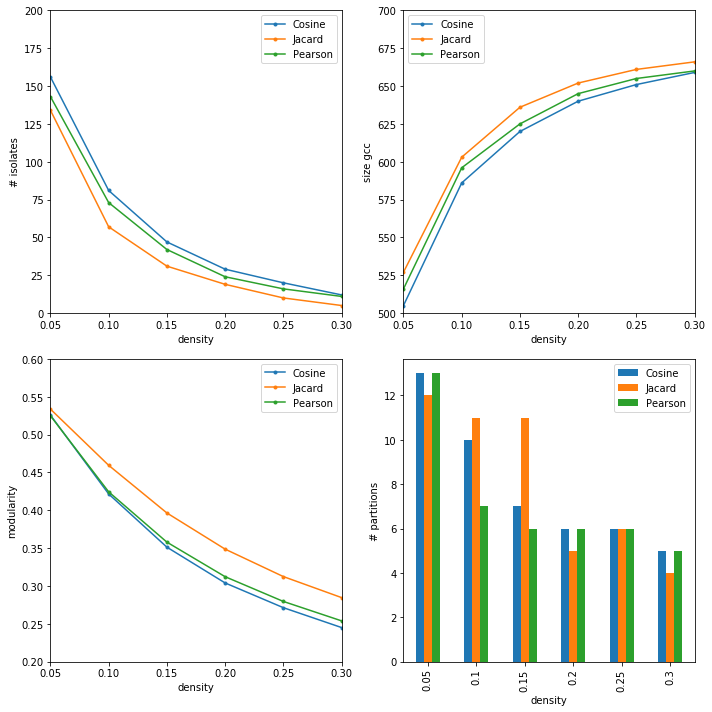

In [45]:
_,axs = plt.subplots(2,2,figsize=(10,10))

(iso_df*len(users)).iloc[:,[0,2,3]].plot(ax=axs[0,0],style='.-')
axs[0,0].set_ylabel('# isolates')
axs[0,0].set_xlabel('density')
axs[0,0].set_xlim((0.05,0.3))
axs[0,0].set_ylim((0.0,200))

gcc_df.iloc[:,[0,2,3]].plot(ax=axs[0,1],style='.-')
axs[0,1].set_ylabel('size gcc')
axs[0,1].set_xlabel('density')
axs[0,1].set_xlim((0.05,0.3))
axs[0,1].set_ylim((500,700))

modularity_df.iloc[:,[0,2,3]].plot(ax=axs[1,0],style='.-')
axs[1,0].set_ylabel('modularity')
axs[1,0].set_xlabel('density')
#axs[1,0].axhline(0.40, color='green', linestyle='--',label = 'modularity: {}'.format(0.40))
axs[1,0].set_xlim((0.05,0.3))
axs[1,0].set_ylim((0.2,0.6))

part_df.iloc[:6,[0,2,3]].plot.bar(ax = axs[1,1],style='.-')
axs[1,1].set_ylabel('# partitions')
axs[1,1].set_xlabel('density')
#axs[1,1].set_xlim((0.05,0.3))
#axs[1,1].set_ylim((0.0,400))

plt.tight_layout()
plt.show()

In [48]:
df_sum = pd.concat([iso_df.iloc[3,:]*len(users),gcc_df.iloc[3,:],part_df.iloc[3,:],modularity_df.iloc[3,:],],axis=1).transpose()
df_sum.index = ['# isolates','size gcc','# communities','modularity']
df_sum.index.name = 'density: 0.2'

In [49]:
df_sum

,Cosine,Euclidean,Jacard,Pearson
density: 0.2,,,,
# isolates,29.000000,287.000000,19.000000,24.000000
size gcc,640.000000,384.000000,652.000000,645.000000
# communities,6.000000,3.000000,5.000000,6.000000
modularity,0.303872,0.060644,0.348563,0.312145


### Quality of Communities

In [46]:
part = defaultdict(pd.Series)

net_conn = slice_density(G_us_pear,0.20)
net_conn.remove_nodes_from(list(nx.isolates(net_conn)))

part_dict = pd.Series(community.best_partition(net_conn)).to_dict()
ser = pd.Series(collections.Counter(part_dict.values()))
part_ser = ser[ser >= 2]
part_ser.index = np.arange(0,len(part_ser))

In [69]:
part_values = set(community.best_partition(net_conn).values())

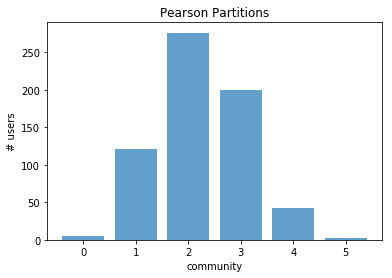

In [47]:
plt.bar(height = part_ser,x=part_ser.index,alpha = 0.7)

plt.title('Pearson Partitions')
plt.ylabel('# users')
plt.xlabel('community')
plt.show()

In [72]:
# write partition as pkl file
f = open("partition_user.pkl","wb")
pickle.dump(community.best_partition(net_conn),f)
f.close()

#### Partition's attributes

In [50]:
df['genres'] = df['genres'].apply(lambda x: x.split('|'))

In [51]:
g = df.groupby('userId')[['genres']].agg(sum)

In [52]:
def normalize(d, target=1):
    
    raw = sum(d.values())
    
    factor = target/raw
     
    return {key: round(value*factor,3) for key,value in d.items() }

In [53]:
def keys_max(d):
    
    v=list(d.values())
    k=list(d.keys())
    
    k_1,k_2,k_3 = sorted(d,key = lambda key: d[key],reverse = True)[0:3]   
    
    return k_1,k_2,k_3

In [54]:
g_norm = g['genres'].apply(lambda x: dict(collections.Counter(x))).apply(normalize).to_dict()

In [55]:
genre_df = pd.DataFrame.from_dict(g['genres'].apply(lambda x: dict(collections.Counter(x))).apply(normalize).to_dict())
genre_df = genre_df.transpose()

In [56]:
dict_part = community.best_partition(net_conn)

In [70]:
part = []
part = [ [u for u,k in dict_part.items() if k == i] for i in part_values]

In [75]:
# Fill Na with 0
genre_df = genre_df.fillna(0)

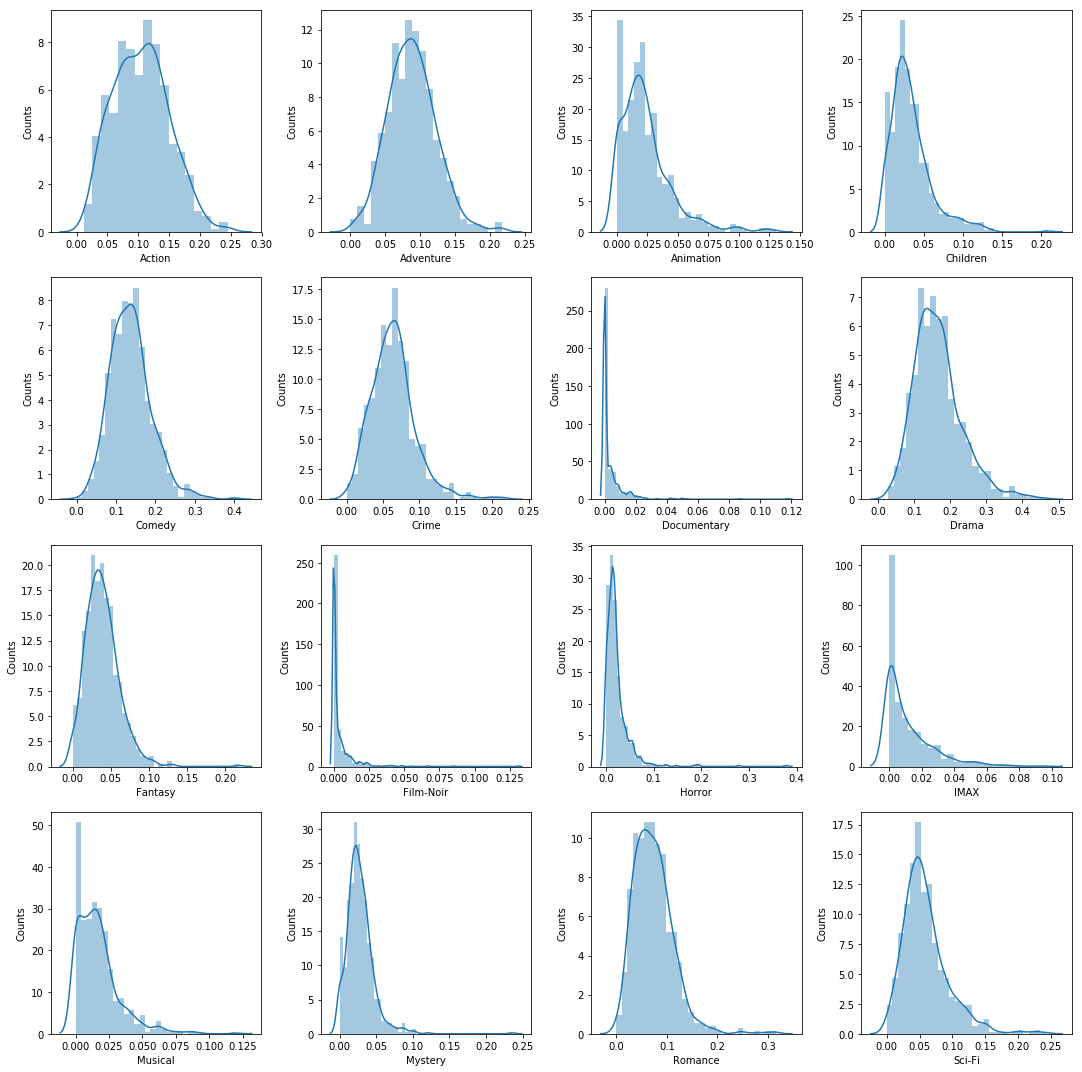

In [78]:
_,axis = plt.subplots(4,4,figsize=(15,15))

for i in range(16):
    sns.distplot(genre_df.iloc[:,i],norm_hist=True,ax = axis[i//4,i%4])
    axis[i//4,i%4].set_ylabel('Counts')

plt.tight_layout()
plt.show()

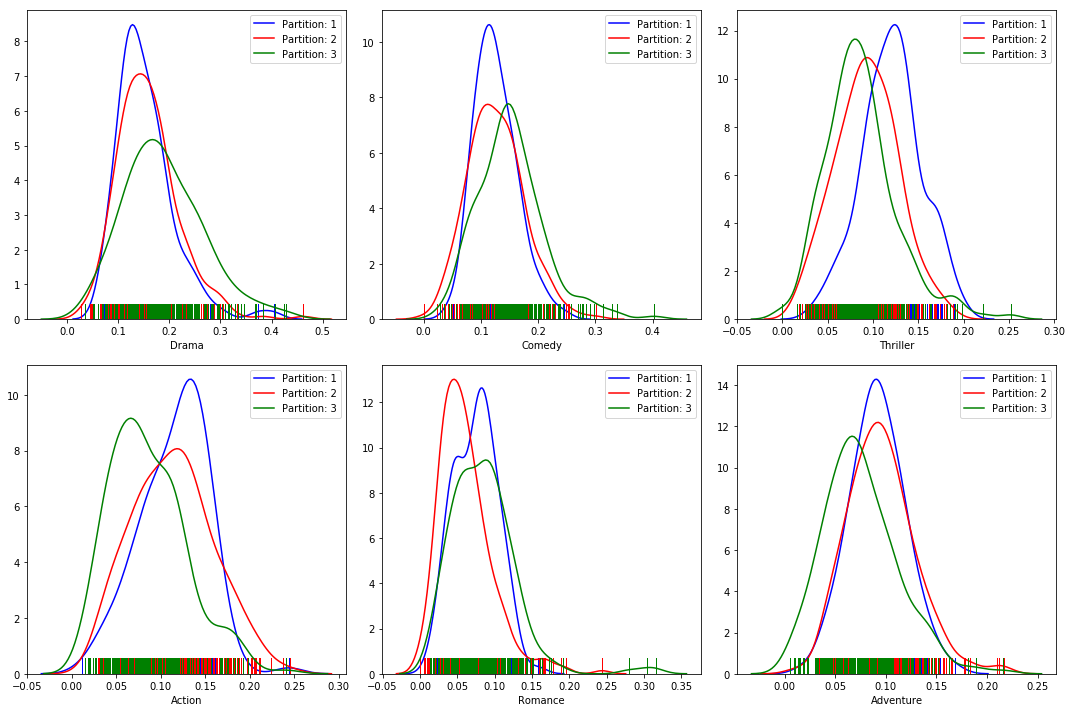

In [79]:
_,axis = plt.subplots(2,3,figsize=(15,10))

sns.distplot(genre_df.loc[part[1],'Drama'], ax=axis[0,0],color='blue',hist=False,norm_hist=True,rug=True,label = 'Partition: {}'.format(1))
sns.distplot(genre_df.loc[part[2],'Drama'], ax=axis[0,0],color='red',hist=False,rug=True,label = 'Partition: {}'.format(2))
sns.distplot(genre_df.loc[part[3],'Drama'], ax=axis[0,0],color='green',hist=False,rug=True,label = 'Partition: {}'.format(3))

sns.distplot(genre_df.loc[part[1],'Comedy'], ax=axis[0,1],color='blue',hist=False,rug=True,label = 'Partition: {}'.format(1))
sns.distplot(genre_df.loc[part[2],'Comedy'], ax=axis[0,1],color='red',hist=False,rug=True,label = 'Partition: {}'.format(2))
sns.distplot(genre_df.loc[part[3],'Comedy'], ax=axis[0,1],color='green',hist=False,rug=True,label = 'Partition: {}'.format(3))

sns.distplot(genre_df.loc[part[1],'Thriller'], ax=axis[0,2],color='blue',hist=False,rug=True,label = 'Partition: {}'.format(1))
sns.distplot(genre_df.loc[part[2],'Thriller'], ax=axis[0,2],color='red',hist=False,rug=True,label = 'Partition: {}'.format(2))
sns.distplot(genre_df.loc[part[3],'Thriller'], ax=axis[0,2],color='green',hist=False,rug=True,label = 'Partition: {}'.format(3))

sns.distplot(genre_df.loc[part[1],'Action'], ax=axis[1,0],color='blue',hist=False,rug=True,label = 'Partition: {}'.format(1))
sns.distplot(genre_df.loc[part[2],'Action'], ax=axis[1,0],color='red',hist=False,rug=True,label = 'Partition: {}'.format(2))
sns.distplot(genre_df.loc[part[3],'Action'], ax=axis[1,0],color='green',hist=False,rug=True,label = 'Partition: {}'.format(3))

sns.distplot(genre_df.loc[part[1],'Romance'], ax=axis[1,1],color='blue',hist=False,rug=True,label = 'Partition: {}'.format(1))
sns.distplot(genre_df.loc[part[2],'Romance'], ax=axis[1,1],color='red',hist=False,rug=True,label = 'Partition: {}'.format(2))
sns.distplot(genre_df.loc[part[3],'Romance'], ax=axis[1,1],color='green',hist=False,rug=True,label = 'Partition: {}'.format(3))

sns.distplot(genre_df.loc[part[1],'Adventure'], ax=axis[1,2],color='blue',hist=False,rug=True,label = 'Partition: {}'.format(1))
sns.distplot(genre_df.loc[part[2],'Adventure'], ax=axis[1,2],color='red',hist=False,rug=True,label = 'Partition: {}'.format(2))
sns.distplot(genre_df.loc[part[3],'Adventure'], ax=axis[1,2],color='green',hist=False,rug=True,label = 'Partition: {}'.format(3))

plt.tight_layout()
plt.show()

### Weight Distribution

In [58]:
count = int(len(G_us_jac.nodes()) * (len(G_us_jac.nodes()) - 1) * 0.20)/2

w0 = sorted(list(G_us_jac.edges(data=True)),key=lambda x: x[2]['weight'],reverse=False)[int(len(G_us_jac.nodes())-count)][2]['weight']

In [59]:
count = int(len(G_us_pear.nodes()) * (len(G_us_pear.nodes()) - 1) * 0.20)/2

w1 = sorted(list(G_us_pear.edges(data=True)),key=lambda x: x[2]['weight'],reverse=False)[int(len(G_us_pear.nodes())-count)][2]['weight']

In [60]:
count = int(len(G_us_cos.nodes()) * (len(G_us_cos.nodes()) - 1) * 0.20)/2

w2 = sorted(list(G_us_cos.edges(data=True)),key=lambda x: x[2]['weight'],reverse=False)[int(len(G_us_jac.nodes())-count)][2]['weight']

In [61]:
count = int(len(G_us_euc.nodes()) * (len(G_us_euc.nodes()) - 1) * 0.20)/2

w3 = sorted(list(G_us_euc.edges(data=True)),key=lambda x: x[2]['weight'],reverse=False)[int(len(G_us_jac.nodes())-count)][2]['weight']

In [62]:
w0,w1,w2,w3

(0.06432748538011696, 0.14712612, 0.1591774, 0.7931671)

In [63]:
wd = np.array([k['weight'] for u,m,k in list(G_us_jac.edges(data=True))])
wd_pear = np.array([k['weight'] for u,m,k in list(G_us_pear.edges(data=True)) if k['weight'] > 0])
wd_cos = np.array([k['weight'] for u,m,k in list(G_us_cos.edges(data=True)) if k['weight'] > 0])
wd_euc = np.array([k['weight'] for u,m,k in list(G_us_euc.edges(data=True)) if k['weight'] > 0])

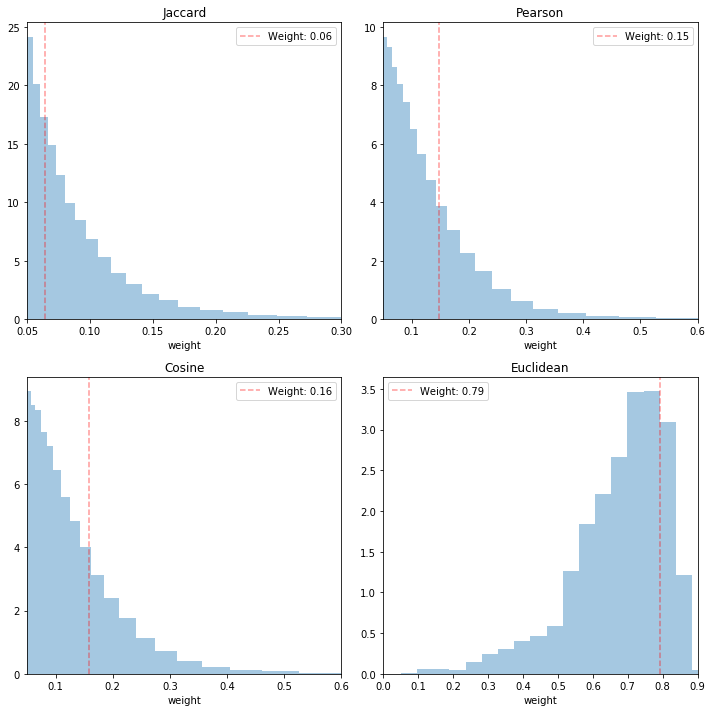

In [65]:
_,axs = plt.subplots(2,2,figsize=(10,10))

sns.distplot(wd,norm_hist=True,kde = False,bins = np.logspace(np.log10(0.05),np.log10(0.3),20),ax = axs[0,0])
axs[0,0].set_xlim((0.05,0.3))
axs[0,0].set_xlabel('weight')
axs[0,0].set_title('Jaccard')
axs[0,0].axvline(w0,c='r',linestyle = '--',label = 'Weight: {}'.format(np.round(w0,2)),alpha= 0.4)
axs[0,0].legend()

sns.distplot(wd_pear,norm_hist=True,kde = False,bins = np.logspace(np.log10(0.05),np.log10(0.6),20),ax = axs[0,1])
axs[0,1].set_xlabel('weight')
axs[0,1].set_xlim((0.05,0.6))
axs[0,1].set_title('Pearson')
axs[0,1].axvline(w1,c='r',linestyle = '--',label = 'Weight: {}'.format(0.15),alpha= 0.4)
axs[0,1].legend()

sns.distplot(wd_cos,norm_hist=True,kde = False,bins = np.logspace(np.log10(0.05),np.log10(0.6),20),ax = axs[1,0])
axs[1,0].set_xlabel('weight')
axs[1,0].set_xlim((0.05,0.6))
axs[1,0].set_title('Cosine')
axs[1,0].axvline(w2,c='r',linestyle = '--',label = 'Weight: {}'.format(0.16),alpha= 0.4)
axs[1,0].legend()

sns.distplot(wd_euc,norm_hist=True,kde = False,bins = 20,ax = axs[1,1])
axs[1,1].set_xlabel('weight')
axs[1,1].set_xlim((0.0,0.9))
axs[1,1].set_title('Euclidean')
axs[1,1].axvline(w3,c='r',linestyle = '--',label = 'Weight: {}'.format(0.79),alpha= 0.4)
axs[1,1].legend()

plt.tight_layout()
plt.show()